In [1]:
import numpy as np
import pandas as pd
import gc
import warnings
warnings.filterwarnings('ignore')
import os
import glob
import os.path as osp
from PIL import Image
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils import data as D
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import time
import cv2
from tqdm import tqdm
import zipfile 
import time
import random as rnd
import torch.backends.cudnn as cudnn
import torch.optim as optim
from torchvision.transforms import functional as TF
from torchvision.utils import make_grid,save_image
from torchvision.datasets import ImageFolder,DatasetFolder
from torch.autograd import Variable
from torchvision.transforms import InterpolationMode
from numpy.random import choice
from numpy.random import seed as np_seed

In [2]:
import re
def numericalSort(value):
    numbers = re.compile(r'(\d+)')
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

bottleneck = 4000
image_size = 256

In [3]:
class Data(D.Dataset):
    def __init__(self, path_mask, path_gt, start_ind = 0, end_ind = 5000):
        super(Data, self).__init__()
        self.masked = []
        self.gt = []
        self.path_mask = path_mask
        self.path_gt = path_gt
        self.transform = transforms.Compose([transforms.ToTensor()])
        files_mask = sorted(glob.glob(os.path.join(path_mask, '*.jpg')), key=numericalSort)[start_ind:end_ind]
        files_gt = sorted(glob.glob(os.path.join(path_gt, '*.jpg')), key = numericalSort)[start_ind:end_ind]
        for mask, gt in  zip(files_mask, files_gt):
            self.masked.append(mask)
            self.gt.append(gt)
        self.len = len(self.masked)
        
    def __getitem__(self, index):
        img_masked = Image.open(self.masked[index])
        img_gt = Image.open(self.gt[index])
        return self.transform(img_masked), self.transform(img_gt)
    
    def __len__(self):
        return self.len
        

In [4]:
path_mask = '/home/sghosal/Project/Image_Inpainting/data_places_mask/'
path_gt = '/home/sghosal/Project/Image_Inpainting/data_places_gt/'
train_imgs = Data(path_mask, path_gt)
val_imgs = Data(path_mask, path_gt, 5000, 7000)

torch.Size([3, 256, 256])


tensor(1.)

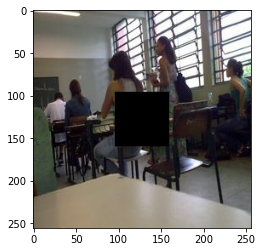

In [5]:
def imshow(img):
    img = img.transpose(0,2).transpose(0,1).numpy()
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    # Checking that I acutally have the pics associated
# i = np.random.randint(0,len(imgs))
sample = train_imgs[0]
x, y = sample
print(x.shape)
imshow(x)
torch.max(x)

In [6]:
train_loader = D.DataLoader(train_imgs, batch_size = 32, shuffle = True, num_workers = 0)
val_loader = D.DataLoader(val_imgs, batch_size = 32, shuffle = False, num_workers = 0)

In [7]:
class Generator(nn.Module):
    def __init__(self,bottleneck):
        super(Generator, self).__init__()

        # Encoder

        # input: image_size * image_size * 3; image_size = 256
        self.encoder_layer_1 = nn.Sequential(
            nn.Conv2d(in_channels=3,out_channels=64,kernel_size=(4,4),stride=2,padding=1),
            nn.LeakyReLU(0.2,True)
        )
        # input: 128 * 128 * 64
        self.encoder_layer_2 = nn.Sequential(
            nn.Conv2d(in_channels=64,out_channels=64,kernel_size=(4,4),stride=2,padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2,True)
        )
        # input: 64 * 64 * 64
        self.encoder_layer_3 = nn.Sequential(
            nn.Conv2d(in_channels=64,out_channels=64,kernel_size=(4,4),stride=2,padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2,True)
        )
        # input: 32 * 32 * 64
        self.encoder_layer_4 = nn.Sequential(
            nn.Conv2d(in_channels=64,out_channels=256,kernel_size=(4,4),stride=2,padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2,True)
        )
        # input: 16 * 16 * 256
        self.encoder_layer_5 = nn.Sequential(
            nn.Conv2d(in_channels=256,out_channels=256,kernel_size=(4,4),stride=2,padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2,True)
        )
        # input: 8 * 8 * 256
        self.encoder_layer_6 = nn.Sequential(
            nn.Conv2d(in_channels=256,out_channels=512,kernel_size=(4,4),stride=2,padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2,True)
        )
        # input: 4 * 4 * 512
        self.bottleneck = nn.Sequential(
            nn.Conv2d(512,bottleneck,kernel_size=(4,4)), 
            nn.BatchNorm2d(bottleneck),
            nn.ReLU()
        )
        # current state: 1 * 1 * bottleneck
        
        # Decoder
        self.decoder_layer_1 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=bottleneck,out_channels=512,kernel_size=(4,4)),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        # Input: 4 * 4 * 512
        self.decoder_layer_2 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=512,out_channels=256,kernel_size=(4,4),stride=2,padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        # Input: 8 * 8 * 256
        self.decoder_layer_3 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=256,out_channels=128,kernel_size=(4,4),stride=2,padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        # Input: 16 * 16 * 128
        self.decoder_layer_4 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=128,out_channels=64,kernel_size=(4,4),stride=2,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        # Input: 32 * 32 * 64
        self.decoder_layer_5 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=64,out_channels=3,kernel_size=(4,4),stride=2,padding=1),
            nn.Tanh()
        )
        # Output: 64 * 64 * 3

    def forward(self,x):
        x = self.encoder_layer_1(x)
        x = self.encoder_layer_2(x)
        x = self.encoder_layer_3(x)
        x = self.encoder_layer_4(x)
        x = self.encoder_layer_5(x)
        x = self.encoder_layer_6(x)
        x = self.bottleneck(x)
        x = self.decoder_layer_1(x)
        x = self.decoder_layer_2(x)
        x = self.decoder_layer_3(x)
        x = self.decoder_layer_4(x)
        x = self.decoder_layer_5(x)

        return x
    

In [8]:
device = ('cuda' if torch.cuda.is_available() else 'cpu')
dev = device

In [9]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        # Input: 64 * 64 * 3
        self.disc_layer_1 = nn.Sequential(
            nn.Conv2d(in_channels=3,out_channels=64,kernel_size=(4,4),stride=2,padding=1),
            nn.LeakyReLU(0.2,True)
        )
        # Input: 32 * 32 * 64
        self.disc_layer_2 = nn.Sequential(
            nn.Conv2d(in_channels=64,out_channels=128,kernel_size=(4,4),stride=2,padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2,True)
        )
        # Input: 16 * 16 * 128
        self.disc_layer_3 = nn.Sequential(
            nn.Conv2d(in_channels=128,out_channels=256,kernel_size=(4,4),stride=2,padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2,True)
        )
        # Input: 8 * 8 * 256
        self.disc_layer_4 = nn.Sequential(
            nn.Conv2d(in_channels=256,out_channels=512,kernel_size=(4,4),stride=2,padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2,True)
        )
        # Input: 4 * 4 * 512
        self.disc_layer_5 = nn.Sequential(
            nn.Conv2d(in_channels=512,out_channels=1,kernel_size=(4,4),stride=1,padding=0),
            nn.Sigmoid()
        )
        # Output: 1 * 1 * 1
    
    def forward(self,x):
        x = self.disc_layer_1(x)
        x = self.disc_layer_2(x)
        x = self.disc_layer_3(x)
        x = self.disc_layer_4(x)
        x = self.disc_layer_5(x)
        x = x.view(-1)
        return x

In [10]:
# Import all needed modules

In [11]:
cudnn.benchmark = False 

# Enable cuda if available
if torch.cuda.is_available():
  Tensor = torch.cuda.FloatTensor
  device = 'cuda'
else :
  Tensor = torch.FloatTensor
  device = 'cpu'


# Number of channel RGB 3
channel = 3 

# Imgage size will be C*256*256
img_size = 256

# Mask size it's the size of center mask Cx64x64
mask_size = 64

# Number of pixels overlapped
overlapPred = 0

# Size of batches
batch_size = 32

#  the lower is res value, the more continuous the output will be.
## Value to generate a random patter of 1 and 0 to create a random region
res = 0.06
density = 0.25
MAX_SIZE = 10000

# Paths 
save_path_discriminator = "./gan/checkpoint_discriminator_2.pth"
save_path_generator = "./gan/checkpoint_generator_2.pth"

# Restore backups
restore = False


In [12]:
def weights_init_normal(m):
    # Initialize model
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

In [13]:
def create_model(bottleneck=4000, gen_lr=0.0002, dis_lr=0.0002, gen_weight_decay=5e-4, dis_weight_decay=5e-4):
    
    latent_dim = bottleneck
    g_net = Generator(latent_dim)
    d_net = Discriminator()
    g_optimizer = optim.Adam(g_net.parameters(), lr=gen_lr, betas=(0.5,0.999), weight_decay=gen_weight_decay)
    d_optimizer = optim.Adam(d_net.parameters(), lr=dis_lr, betas=(0.5,0.999), weight_decay=dis_weight_decay)
    
    g_net = g_net.to(dev)
    d_net = d_net.to(dev)
    return g_net,d_net,g_optimizer,d_optimizer


In [14]:
def training(train_loader,test_loader= None, labels_noise=False,wtl2= 0.999,last_epoch=3,save_photos_interval=10,overlapL2Weight=10):
    '''
    train_loader: Dataloader of train data
    test_loader : Dataloader of test data
    labels_noise: Boolean that enable labels smoothing and flipping
    wtl2: param to weights losses 
    last_epoch: number of last epoch
    save_photos_interval: set interval of every x epoch generate photos to compare
    overlapL2Weight: weights amplified 

    '''
    # Define labels 
    total_time = 0 
    # Create the models 
    g_net,d_net,g_optimizer,d_optimizer = create_model()
    If backup it's available load it 
    if os.path.isfile(save_path_discriminator) and os.path.isfile(save_path_generator) and restore:
        checkpoint_d =  torch.load(save_path_discriminator)
        checkpoint_g =  torch.load(save_path_generator)
        d_net.load_state_dict(checkpoint_d['d_state_dict'])
        d_optimizer.load_state_dict(checkpoint_d['optimizer_state_dict'])
        d_loss = checkpoint_d['loss']
        d_loss_fake = checkpoint_d['loss_fake']
        d_loss_real = checkpoint_d['loss_real']
        g_net.load_state_dict(checkpoint_g['g_state_dict'])
        g_optimizer.load_state_dict(checkpoint_g['optimizer_state_dict'])
        g_loss = checkpoint_g['loss']    
        g_loss_pixel = checkpoint_g['loss_pixel']
        g_loss_adv = checkpoint_g['loss_adv']
        epoch_backup = checkpoint_g['epoch']+1
        print("Discriminator and Generator restored")
    else:
        epoch_backup = 0 
        g_net.apply(weights_init_normal)
        d_net.apply(weights_init_normal)
        print("weight applied")
    try:
        for epoch in range(epoch_backup,last_epoch):
            # Losses
            start = time.time()
            sum_d_loss = 0
            sum_d_fake_loss = 0
            sum_d_real_loss = 0
            sum_g_loss = 0
            sum_g_loss_adv = 0
            sum_g_loss_pixel = 0
            d_net.train()
            g_net.train()
            i = 0
    
            for i,(x,y) in tqdm(enumerate(train_loader)):
                batch_length = x.shape[0]
                valid = Variable(Tensor(batch_length).fill_(1.0), requires_grad=False)
                fake = Variable(Tensor(batch_length).fill_(0.0), requires_grad=False)
                x = x.to(device)
                y = y.to(device)
                i+=1
                masked_parts = y[:,:,96:160,96:160]
                #masked_parts are the center of the images 
                masked_parts = Variable(masked_parts.type(Tensor))
                masked_imgs = x.clone()

                
                # Reset discriminator gradient
                d_optimizer.zero_grad()

                # Forward (discriminator, real)
                output = d_net(masked_parts) 
                # Compute loss (discriminator, real)
               
                d_real_loss =  F.binary_cross_entropy(output, valid)
                
                # Backward (discriminator, real)
                d_real_loss.backward()
                sum_d_real_loss += d_real_loss.item()         
                g_output = g_net(masked_imgs)
                output = d_net(g_output.detach()) 
                d_fake_loss = F.binary_cross_entropy(output, fake)
                # Backward (discriminator, fake)
                d_fake_loss.backward()
                sum_d_fake_loss += d_fake_loss.item()           
                d_loss = 0.5*(d_fake_loss + d_real_loss)
                sum_d_loss += d_loss.item()
                # Update discriminator
                d_optimizer.step()
                
                ### Generator 
                g_optimizer.zero_grad()
                # Forward (generator)
                output =  d_net(g_output)
                # Compute adversarial loss
                g_loss_adv = F.binary_cross_entropy(output, valid)            
                mask_size-overlapPred,overlapPred:mask_size-overlapPred] = wtl2
                g_loss_pixel = (g_output-masked_parts).pow(2)
                g_loss_pixel = g_loss_pixel.mean()
                g_loss = (1-wtl2) * g_loss_adv + wtl2 * g_loss_pixel
                sum_g_loss_adv += g_loss_adv.item()
                sum_g_loss_pixel += g_loss_pixel.item()
                sum_g_loss += g_loss.item()
                # Backward (generator)
                g_loss.backward()
                # Update generator
                g_optimizer.step()
                if epoch % 2 == 0:
                    torch.save(g_net.state_dict(), './gan/generator.pt')
                    torch.save({'g_state_dict': g_net.state_dict(),
                            'optimizer_state_dict': g_optimizer.state_dict(),
                            'loss': g_loss,
                            'loss_pixel': g_loss_pixel,
                            'loss_adv': g_loss_adv,
                            'epoch':epoch,
                            }, save_path_generator)

                    torch.save({'d_state_dict': d_net.state_dict(),
                                'optimizer_state_dict': d_optimizer.state_dict(),
                                'loss_fake': d_fake_loss,
                                'loss_real': d_real_loss,
                                'loss': d_loss,
                                'epoch': epoch
                                }, save_path_discriminator)
                    
            # Epoch end, print losses
            epoch_d_loss = sum_d_loss/len(train_loader)
            epoch_d_real_loss = sum_d_real_loss/len(train_loader)
            epoch_d_fake_loss = sum_d_fake_loss/len(train_loader)
            epoch_g_loss_adv = sum_g_loss_adv/len(train_loader)
            epoch_g_loss_pixel = sum_g_loss_pixel/len(train_loader)
            epoch_g_loss = sum_g_loss/len(train_loader)
            end = time.time()   
            time_epoch = (end - start)/60
            total_time +=time_epoch

    except KeyboardInterrupt:
          print("Interrupted")

In [15]:
training(train_loader)

In [16]:
def imshow_again(img):
    img = img.transpose(0,2).transpose(0,1).numpy()
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

In [28]:
model = Generator(4000)
device = ('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
model.load_state_dict(torch.load('./gan/generator.pt'))
model.eval()
with torch.no_grad():
    for i,(x,y) in enumerate(val_loader):
        if i == 5:
            break
        test = x
        gt = y
        out2 = model(x.to(device))
        for j in range(32):
            x[j][:,96:160,96:160] = out2[j]
            plt.imshow(imshow_again(x[j]))
            plt.savefig(f'./results/gan/gan__batch_{i}_{j}.png', bbox_inches = 'tight')
    

In [23]:
model.eval()
with torch.no_grad():
    acc_val = []
    for i,(x,y) in tqdm(enumerate(val_loader)):
        test = x
        gt = y
        out2 = model(x.to(device))
        for j in range(len(x)):
            x[j][:,96:160,96:160] = out2[j]
            loss = (x[:,:,96:160,96:160] - y[:,:,96:160,96:160]) ** 2 
            loss = torch.sum(loss)/32
            acc_val.append(loss)
            
with torch.no_grad():
    acc_train = []
    for i,(x,y) in tqdm(enumerate(train_loader)):
        test = x
        gt = y
        out2 = model(x.to(device))
        for j in range(len(x)):
            x[j][:,96:160,96:160] = out2[j]
            loss = (x[:,:,96:160,96:160] - y[:,:,96:160,96:160]) ** 2 
            loss = torch.sum(loss)/32
            acc_train.append(loss)
    

63it [01:30,  1.43s/it]
157it [03:38,  1.39s/it]


In [24]:
sum(acc_val)/len(acc_val)

tensor(1768.6992)

In [25]:
sum(acc_train)/len(acc_train)

tensor(1798.8352)